In [424]:
import numpy as np
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import sys

In [425]:
def encode_lable(y, num_classes):
    y_gt = np.zeros((len(y), num_classes))
    for i in range(0, len(y)):
        y_gt[i, y[i]] = 1
    return y_gt

In [426]:
def h(theta, X):
    return 1.0 / (1 + np.exp(-np.dot(X, theta)))

In [427]:
def sigm_derivative(theta, X):
    return h(theta, X) * (1 - h(theta, X))

In [428]:
def loss(y_gt, y_pred):
    cross_entropy_error = 0.0
    for i in range(0, len(y_gt)):
        for j in range(0, len(y_gt[i])):
            cross_entropy_error -= (y_gt[i][j] * np.log(y_pred[i][j]) + (1 - y_gt[i][j]) * np.log(1 - y_pred[i][j]))
    return cross_entropy_error / len(y_gt)

In [429]:
def CEderivative(X, y_gt, y_pred):
    return np.dot(y_pred - y_gt, X) / len(y_gt)

In [431]:
(dx_train, dy_train), (x_test, y_test) = cifar10.load_data()

In [432]:
print('x_train shape:', dx_train.shape)
print(dx_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [433]:
dy_train = encode_lable(dy_train, 10)
y_test = encode_lable(y_test, 10)

In [434]:
dx_train = np.asarray([list(x.flat) for x in dx_train])
x_test = np.asarray([list(x.flat) for x in x_test])

In [435]:
p = np.random.permutation(dx_train.shape[0])
x_train = dx_train[p[0:int(len(dx_train)*0.8)], :]
y_train = dy_train[p[0:int(len(dx_train)*0.8)]]
x_val = dx_train[p[int(len(dx_train)*0.8):], :]
y_val = dy_train[p[int(len(dx_train)*0.8):]]
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (40000, 3072)
y_train shape: (40000, 10)
x_val shape: (10000, 3072)
y_val shape: (10000, 10)
x_test shape: (10000, 3072)
y_test shape: (10000, 10)


In [436]:
x_train = (x_train - np.mean(x_train, axis = 0)) / np.var(x_train, axis = 0)
x_val = (x_val - np.mean(x_val, axis = 0)) / np.var(x_val, axis = 0)
x_test = (x_test - np.mean(x_test, axis = 0)) / np.var(x_test, axis = 0)

In [430]:
def forward(thetas, X):
    num_layers = thetas.shape[0]
    outs = []
    for t in range(0, num_layers): #проходим по всем слоям (все слои с сигмоидальной функцией активации)
        if t == 0:
            outs.append(np.array([h(thetas[t][:, i], X) for i in range(0, thetas[t].shape[1])]).T)
        else:
            outs.append(np.array([h(thetas[t][:, i], np.asarray(outs[t-1])) for i in range(0, thetas[t].shape[1])]).T)
    return [out for out in outs]

In [506]:
def backward(X, y_gt, thetas):
    num_features = X.shape[1]
    num_classes = y_gt.shape[1]
    outs = forward(thetas, X)
    num_layers = len(outs)
    d_theta = []
    d_theta.append(np.zeros([num_features, outs[0].shape[1]]))
    for i in range(0, num_layers - 1):
        d_theta.append(np.zeros([outs[i].shape[1], outs[i+1].shape[1]]))
    #выходной слой
    for class_no in range(0, num_classes):
        d_theta[1][:, class_no] = CEderivative(outs[0], y_gt[:, class_no], outs[1][:, class_no])
    d3 = outs[1] - y_gt
    #скрытый слой
    tmp_th2 = np.dot(d3, thetas[1].T)
    tmp_th2 = tmp_th2 * sigm_derivative(thetas[0], X)
    d_theta[0] = np.dot( X.T, tmp_th2)
    #d_theta[0] = np.dot(X.T, np.dot(d3, thetas[1].T)*sigm_derivative(thetas[0], X))
    return d_theta

Initial loss : 21.34505127041066


Epoch 0/1 ...........
Loss train: 2.824025992968512 
Loss val: 2.893870122621053 
Train accuracy :  0.078175 
Validation accuracy :  0.16720000000000002


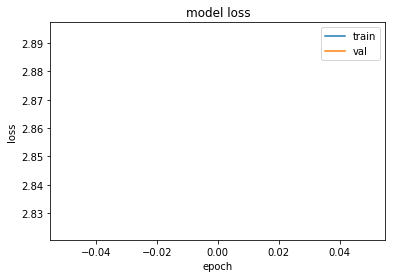

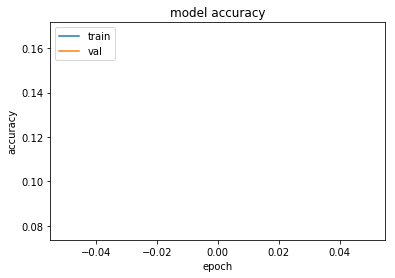

In [513]:
batch_size = 1000
num_epochs = 1
alpha = 0.5
np.random.seed(0)
history_loss_train,history_loss_val, history_acc_train, history_acc_val = [],[],[],[]
num_train_samples = x_train.shape[0]
num_batches = num_train_samples // batch_size
layers_size = [3072,64, 10]
thetas = np.asarray([np.random.randn(layers_size[i], layers_size[i+1]) for i in range(0, len(layers_size)-1)])
y_pred = forward(thetas, x_train)
loss_val = loss(y_train, y_pred[-1])
print("Initial loss :", loss_val)
for i in range(0, num_epochs):
    p = np.random.permutation(num_train_samples)
    print('\n\nEpoch %d/%d ' % (i, num_epochs), end='.')
    for batch_no in range(0, num_batches):
        if np.mod(batch_no, num_batches // 10) == 0:
            print('.', end='')
            sys.stdout.flush()
        x_train_batch = x_train[p[batch_no * batch_size : (batch_no + 1) * batch_size], :]
        y_train_batch = y_train[p[batch_no * batch_size: (batch_no + 1) * batch_size]]
        d_theta = backward(x_train_batch, y_train_batch, thetas)
        for i in range(0,len(d_theta)):
            thetas[i] =thetas[i] - alpha*d_theta[i] 
    
    
    #loss train
    pred_train_probs = forward(thetas, x_train)
    pred_train_labels = np.argmax(pred_train_probs[-1], axis=1)
    loss_train = loss(y_train, pred_train_probs[-1])
    history_loss_train.append(loss_train)
    
    #loss val
    pred_val_probs = forward(thetas, x_val)
    pred_val_labels = np.argmax(pred_val_probs[-1], axis=1)
    loss_val = loss(y_val, pred_val_probs[-1])
    history_loss_val.append(loss_val)
    
    #pred_val_probs = forward(thetas, x_val)
    #pred_val_labels = np.argmax(pred_train_probs[len(layers_size) - 2], axis=1)
    history_acc_train.append((1-np.mean(pred_train_labels != np.argmax(y_train))))
    history_acc_val.append((1 - np.mean(pred_val_labels != np.argmax(y_val))))
    print("\nLoss train:", loss_train,
          "\nLoss val:", loss_val,
          "\nTrain accuracy : ", (1-np.mean(pred_train_labels != np.argmax(y_train))),
          "\nValidation accuracy : ", (1 - np.mean(pred_val_labels != np.argmax(y_val))))
    plt.plot(history_loss_train)
    plt.plot(history_loss_val)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    
    plt.plot(history_acc_train)
    plt.plot(history_acc_val)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

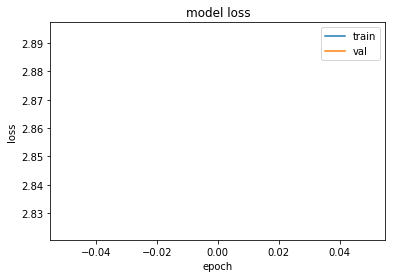

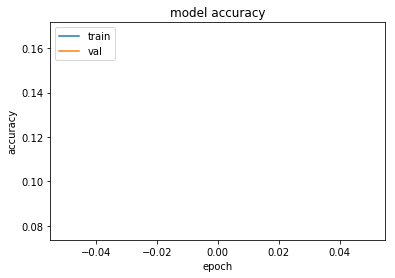

In [514]:
plt.plot(history_loss_train)
plt.plot(history_loss_val)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.plot(history_acc_train)
plt.plot(history_acc_val)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()